In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

import pymc as pm

In [2]:
sns.set_theme(style="ticks")

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
# Dummy data placeholders
time, states = 100, 2 
tr_predictors, em_predictors = 3, 1
em_output = 1

u_tr = xr.DataArray( rng.normal(size=(time, tr_predictors)), dims=("time", "tr_wts"))

u_em = xr.DataArray( rng.normal(size=(time)), dims=("time"))

y = xr.DataArray( rng.vonmises(2.5, 1, size=(time)), dims=("time"))

Text(0.5, 0, 'y')

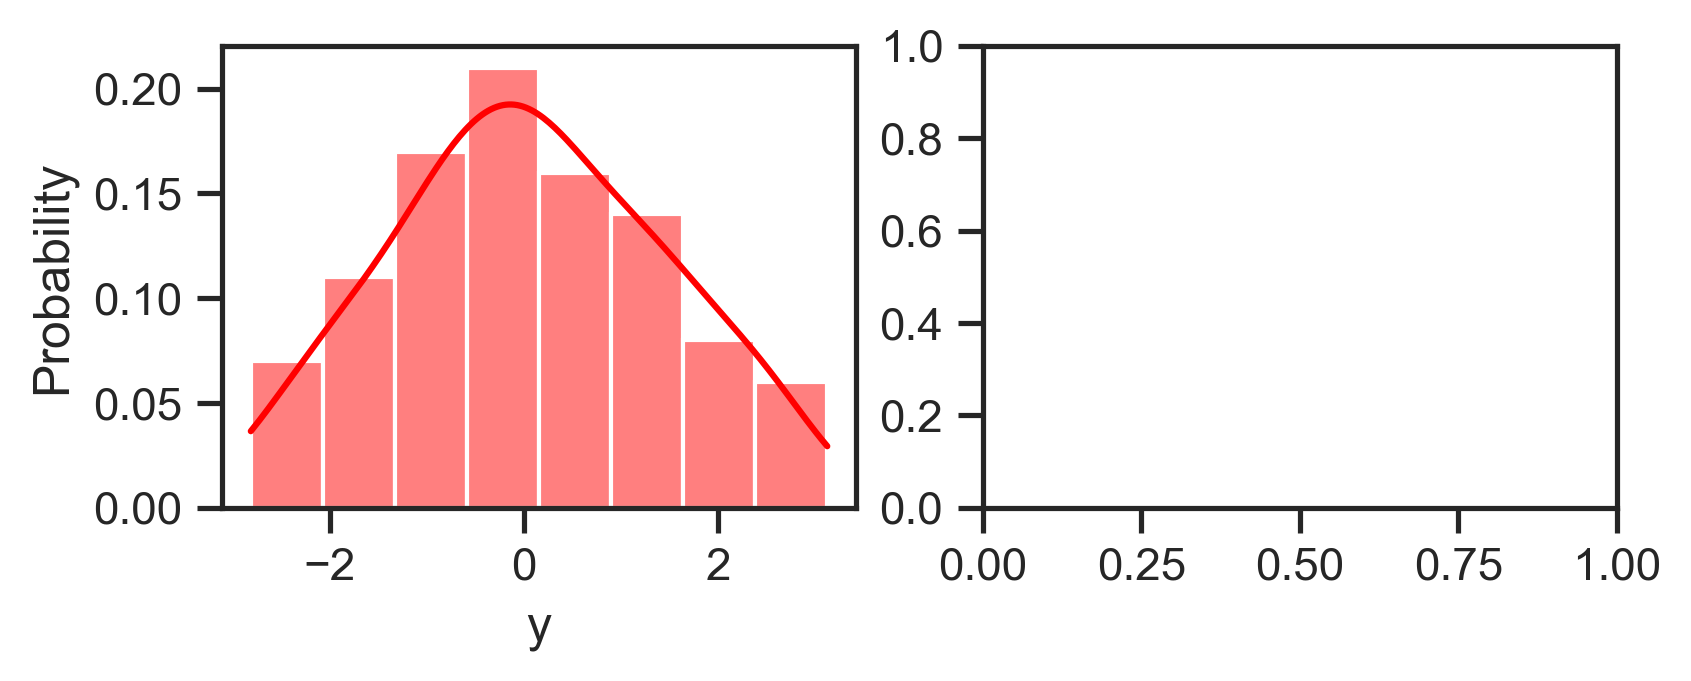

In [9]:
y = xr.DataArray( rng.vonmises(0.1, 0.5, size=(time)), dims=("time"))

# Make 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi = 300)

sns.histplot(
    y, 
    ax=axs[0], 
    kde=True,
    stat="probability",
    color="red",
).set_xlabel("y")


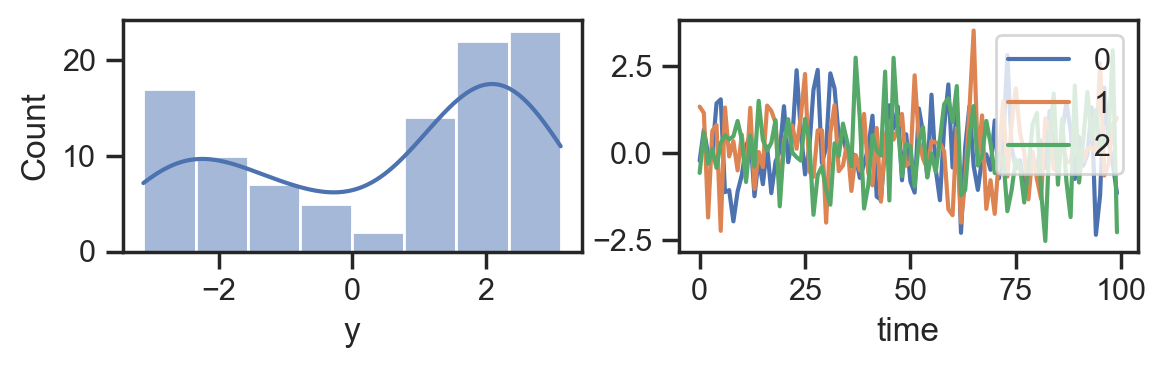

In [4]:
# Make 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi = 200)

sns.histplot(
    y, 
    ax=axs[0], 
    kde=True,
    stat="count",
).set_xlabel("y")

sns.lineplot(
    data=u_tr,
    ax=axs[1],
    dashes=False,
).set_xlabel("time")

plt.tight_layout()
plt.show()

$$

z_t \mid x_t^{tr}, \theta \sim Cat( a + b \cdot x_t^{tr} )

\\

y_t \mid z_t, x_t^{em}, \theta \sim VonMises( y_t \mid  C_{z_t} \cdot x_t^{em}, \kappa_{z_t})

$$

In [ ]:
with pm.Model() as model:
    # Priors
    a = pm.Normal("a", mu=0, sigma=5, shape=states)
    b = pm.Normal("b", mu=0, sigma=5, shape=(states, tr_predictors))
    
    # Linear predictors for class probabilities
    eta = a + pm.math.dot(u_tr.to_numpy(), b.T)
    class_probs = pm.math.softmax(eta)
    
    # Component parameters
    mu_sens = u_em.to_numpy() * 1
    mu_insens = u_em.to_numpy() * 0.1
    mu = np.stack([mu_sens, mu_insens], axis=-1)  # Shape (100, 2)
    kappa = np.array([6, 0.5])  # Shape (2,)
    
    # Mixture model using MixtureSameFamily
    y_obs = pm.Mixture(
        "y_obs",
        w=pm.Categorical.dist(p=class_probs),
        comp_dists=[pm.VonMises.dist(mu=mu, kappa=kappa)],
        observed=y.to_numpy()
    )
    
    # Sample from the posterior
    trace = pm.sample(1000)

In [ ]:
import numpy as np
import pymc as pm
import xarray as xr
import numpy.random as rng

# Dummy data placeholders
time, states = 100, 2 
tr_predictors, em_predictors = 3, 1

u_tr = pm.Data( "u_tr", rng.normal(size=(time, tr_predictors)))
u_em = pm.Data( "u_em", rng.normal(size=(time)))
y = pm.Data( "y", rng.vonmises(2.5, 1, size=(time)), dims=("time"))

with pm.Model() as model:
    # Priors
    a = pm.Normal("a", mu=0, sigma=5, shape=states)
    b = pm.Normal("b", mu=0, sigma=5, shape=(states, tr_predictors))
    
    # Linear predictors for class probabilities
    eta = a + pm.math.dot(u_tr, b.T)
    class_probs = pm.math.softmax(eta)
    
    # Component parameters
    mu_sens = u_em * 1
    mu_insens = u_em * 0.1
    mu = pm.math.stack([mu_sens, mu_insens], axis=0)  # Shape (time, states)

    kappa = pm.math.constant([6, 0.5])  # Shape (states,)
    

    

    # Sample from the posterior
    trace = pm.sample(1000)


AttributeError: module 'pymc' has no attribute 'MixtureSameFamily'

In [ ]:
import numpy as np
import pymc as pm
import xarray as xr
import numpy.random as rng

# Dummy data placeholders
time, states = 100, 2 
tr_predictors = 3

rng.seed(42)
u_tr = xr.DataArray(rng.normal(size=(time, tr_predictors)), dims=("time", "tr_wts"))
u_em = xr.DataArray(rng.normal(size=(time)), dims=("time"))
y = xr.DataArray(rng.vonmises(2.5, 1, size=(time)), dims=("time"))

with pm.Model() as model:
    # Priors
    a = pm.Normal("a", mu=0, sigma=5, shape=states)  # Shape (states,)
    b = pm.Normal("b", mu=0, sigma=5, shape=(states, tr_predictors))  # Shape (states, tr_predictors)
    
    # Linear predictors for class probabilities
    eta = a + pm.math.dot(u_tr, b.T)  # Shape (time, states)
    class_probs = pm.math.softmax(eta)  # Shape (time, states)
    
    # Component parameters
    u_em_shared = pm.Data("u_em_shared", u_em)  # Shape (time,)
    mu_sens = u_em_shared * 1.0       # Shape (time,)
    mu_insens = u_em_shared * 0.1     # Shape (time,)
    
    # Stack mu_sens and mu_insens along a new axis
    mu = pm.math.stack([mu_sens, mu_insens], axis=1)  # Shape (time, states)
    kappa_values = np.array([6, 0.5])  # Shape (states,)
    kappa = pm.math.constant(kappa_values)
    
    # Initialize lists to hold latent variables and observed variables
    z = []
    y_obs = []
    
    for t in range(time):
        # Mixture weights and component parameters for time t
        class_prob_t = class_probs[t]  # Shape (states,)
        mu_t = mu[t]                   # Shape (states,)
        
        # Latent class assignment for time t
        z_t = pm.Categorical(f"z_{t}", p=class_prob_t)
        z.append(z_t)
        
        # Index mu_t and kappa using pm.math.take
        mu_obs_t = pm.math.take(mu_t, z_t)
        kappa_obs_t = pm.math.take(kappa, z_t)
        
        # Observed data for time t
        y_t = pm.VonMises(
            f"y_obs_{t}",
            mu=mu_obs_t,
            kappa=kappa_obs_t,
            observed=y[t]
        )
        y_obs.append(y_t)
    
    # Sample from the posterior
    trace = pm.sample(1000, cores=2, tune=1000)


NotImplementedError: Cannot convert <xarray.DataArray (time: 100, tr_wts: 3)> Size: 2kB
array([[ 0.49671415, -0.1382643 ,  0.64768854],
       [ 1.52302986, -0.23415337, -0.23413696],
       [ 1.57921282,  0.76743473, -0.46947439],
       [ 0.54256004, -0.46341769, -0.46572975],
       [ 0.24196227, -1.91328024, -1.72491783],
       [-0.56228753, -1.01283112,  0.31424733],
       [-0.90802408, -1.4123037 ,  1.46564877],
       [-0.2257763 ,  0.0675282 , -1.42474819],
       [-0.54438272,  0.11092259, -1.15099358],
       [ 0.37569802, -0.60063869, -0.29169375],
       [-0.60170661,  1.85227818, -0.01349722],
       [-1.05771093,  0.82254491, -1.22084365],
       [ 0.2088636 , -1.95967012, -1.32818605],
       [ 0.19686124,  0.73846658,  0.17136828],
       [-0.11564828, -0.3011037 , -1.47852199],
       [-0.71984421, -0.46063877,  1.05712223],
       [ 0.34361829, -1.76304016,  0.32408397],
       [-0.38508228, -0.676922  ,  0.61167629],
       [ 1.03099952,  0.93128012, -0.83921752],
       [-0.30921238,  0.33126343,  0.97554513],
...
       [-0.79252074, -0.11473644,  0.50498728],
       [ 0.86575519, -1.20029641, -0.33450124],
       [-0.47494531, -0.65332923,  1.76545424],
       [ 0.40498171, -1.26088395,  0.91786195],
       [ 2.1221562 ,  1.03246526, -1.51936997],
       [-0.48423407,  1.26691115, -0.70766947],
       [ 0.44381943,  0.77463405, -0.92693047],
       [-0.05952536, -3.24126734, -1.02438764],
       [-0.25256815, -1.24778318,  1.6324113 ],
       [-1.43014138, -0.44004449,  0.13074058],
       [ 1.44127329, -1.43586215,  1.16316375],
       [ 0.01023306, -0.98150865,  0.46210347],
       [ 0.1990597 , -0.60021688,  0.06980208],
       [-0.3853136 ,  0.11351735,  0.66213067],
       [ 1.58601682, -1.2378155 ,  2.13303337],
       [-1.9520878 , -0.1517851 ,  0.58831721],
       [ 0.28099187, -0.62269952, -0.20812225],
       [-0.49300093, -0.58936476,  0.8496021 ],
       [ 0.35701549, -0.6929096 ,  0.89959988],
       [ 0.30729952,  0.81286212,  0.62962884]])
Dimensions without coordinates: time, tr_wts to a tensor variable.

In [3]:
import numpy as np
import pymc as pm
import xarray as xr
import numpy.random as rng

# Dummy data placeholders
time, states = 100, 2 
tr_predictors = 3

rng.seed(42)
u_tr_data = rng.normal(size=(time, tr_predictors))
u_em_data = rng.normal(size=(time))
y_data = rng.vonmises(2.5, 1, size=(time))

with pm.Model() as model:
    # Priors
    a = pm.Normal("a", mu=0, sigma=5, shape=states)
    b = pm.Normal("b", mu=0, sigma=5, shape=(states, tr_predictors))
    
    # Data as shared variables
    u_tr_shared = pm.Data("u_tr_shared", u_tr_data)
    u_em_shared = pm.Data("u_em_shared", u_em_data)
    y_shared = pm.Data("y_shared", y_data)
    
    # Linear predictors for class probabilities
    eta = a + pm.math.dot(u_tr_shared, b.T)
    class_probs = pm.math.softmax(eta)
    
    # Component parameters
    mu_sens = u_em_shared * 1.0
    mu_insens = u_em_shared * 0.1
    mu = pm.math.stack([mu_sens, mu_insens], axis=1)
    kappa_values = np.array([6, 0.5])
    kappa = pm.math.constant(kappa_values)
    
    z = []
    y_obs = []
    
    for t in range(time):
        # Mixture weights and component parameters for time t
        class_prob_t = class_probs[t]
        mu_t = mu[t]
        
        # Latent class assignment for time t
        z_t = pm.Categorical(f"z_{t}", p=class_prob_t)
        z.append(z_t)
        

        # For more than 2 states, use pm.math.take
        mu_obs_t = pm.math.switch(pm.math.eq(z_t, 0), mu_t[0], mu_t[1])
        kappa_obs_t = pm.math.switch(pm.math.eq(z_t, 0), kappa[0], kappa[1])
        
        # Observed data for time t
        y_t = pm.VonMises(
            f"y_obs_{t}",
            mu=mu_obs_t,
            kappa=kappa_obs_t,
            observed=y_shared[t]
        )
        y_obs.append(y_t)
    
    # Sample from the posterior
    trace = pm.sample(1000, cores=2, tune=1000)


TypeError: Variables that depend on other nodes cannot be used for observed data.The data variable was: Subtensor{i}.0